5081


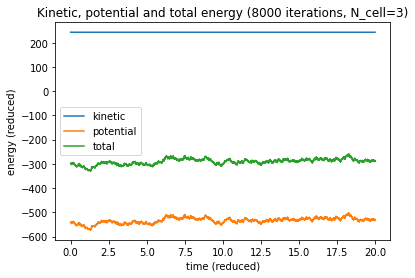

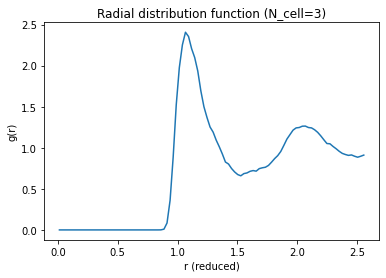

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi
from itertools import product

sigma = 0.3405  # nm
t0 = 2.157  # ps
n_bins = 100

T_0 = 1.50  # temperature
rho = 0.7976  # density of Argon in reduced units
# T_0 = 0.71  # temperature
# rho = 0.844  # density of Argon in reduced units

n_frames = 8000
dt = 20/n_frames  # time step size
N_cell = 3  # number of fcc unitcells in one direction
N = 4 * N_cell ** 3  # the total number of particles in the system
L_box = (N / rho) ** (1 / 3.0)  # length of the whole simulation box
L_cell = L_box / N_cell  # length of a unitcell
F = np.zeros((N, N, 3))  # matrix that contains all forces
ind = np.triu_indices(N, k=1)  # indices of upper triangular matrix


def IC_pos(N_cell, L_cell):
    '''
    use fcc structure to initilize positions
    '''
    pos = [[[x,  y, z],
            [x, 0.5 + y, 0.5 + z],
            [0.5 + x, y, 0.5 + z],
            [0.5 + x, 0.5 + y, z]]
           for x, y, z in product(range(N_cell), range(N_cell), range(N_cell))]
    pos = np.array(pos).reshape((-1, 3))
    return pos * L_cell


def IC_vel(N):
    '''
    Maxwell-Boltzman distribution is a normal distribution
    '''
    vel = np.sqrt(T_0) * np.random.randn(N, 3)
    vel -= np.average(vel, axis=0)
    return vel


def find_energy(pos, vel, L_box=L_box):
    r_vec = pos[ind[0]] - pos[ind[1]]
    r_vec = r_vec - np.rint(r_vec / L_box) * L_box
    r_sq = np.sum(r_vec**2, axis=1)
    pot = np.sum(4 / r_sq ** 6 - 4 / r_sq ** 3)
    kin = 0.5 * np.sum(vel**2)
    return kin, pot


def time_step(pos, vel):
    prop_pos = np.mod(pos + (np.random.rand(N, 3) - 0.5)
                      * (np.sqrt(T_0) * dt) * 4, L_box)
    prop_vel = vel

    prop_kin, prop_pot = find_energy(prop_pos, prop_vel)
    kin, pot = find_energy(pos, vel)

    acc = np.minimum(1, np.exp(-1/(T_0) * (prop_pot - pot)))

    accepted = np.random.rand(1) < acc
    if accepted:
        vel, pos = prop_vel, prop_pos
        pot, kin = prop_pot, prop_kin
    else:
        vel, pos = vel, pos
        pot, kin = pot, kin
    return pos, vel, pot, kin, accepted


def simulate(f, h_r, bins, drs, dvs):
    kins, pots, Ps = [], [], []
    pos = IC_pos(N_cell, L_cell)
    prev_pos = pos
    vel = IC_vel(N)
    prev_vel = vel
    dr, dv = 0, 0
    # F = find_force(pos)[0]
    n_accepted = 0
    for i in range(5*n_frames):
        pos, vel, pot, kin, accepted = time_step(pos, vel)
        if i >= 4*n_frames:  # production run
            kins.append(kin)
            pots.append(pot)

            SI_pos = pos*sigma
            SI_vel = vel*sigma/t0

            r_vec = pos[ind[0]] - pos[ind[1]]
            r_vec = r_vec - np.rint(r_vec / L_box) * L_box
            r_sq = np.sum(r_vec**2, axis=1)
            h_r += np.histogram(np.sqrt(r_sq), bins)[0]
            n_accepted += int(accepted)

        else:  # equillirum run
            vel *= np.sqrt(N * 3 * T_0 / (2 * kin))
        prev_pos = pos
        prev_vel = vel

    print(n_accepted)
    return np.array(kins), np.array(pots), np.array(Ps)


# The simulation starts here
if __name__ == "__main__":
    h_r = np.zeros(n_bins)
    bins = np.linspace(0, L_box/2, n_bins+1)

    drs = []
    dvs = []

    with open('argon.gro', 'w') as f:
        kins, pots, Ps = simulate(f, h_r, bins, drs, dvs)
    times = np.arange(len(kins)) * dt

    # plot the energy vs time results
    plt.plot(times, kins)
    plt.plot(times, pots)
    plt.plot(times, kins+pots)
    plt.legend(['kinetic', 'potential', 'total'])
    plt.xlabel('time (reduced)')
    plt.ylabel('energy (reduced)')
    plt.title(
        f'Kinetic, potential and total energy ({n_frames} iterations, N_cell={N_cell})')
    plt.savefig('images/energy.png')
    plt.show()

    n_r = (h_r*2/((N-1)*(n_frames)))
    g_r = n_r/(4/3*pi*((bins[1:])**3 - (bins[:-1])**3)*rho)
    plt.plot(bins[:n_bins]+(bins[1]-bins[0])/2, g_r)
    plt.title(f'Radial distribution function (N_cell={N_cell})')
    plt.savefig(f'images/g_r(N_cell={N_cell}).png')
    plt.xlabel('r (reduced)')
    plt.ylabel('g(r)')
    plt.show()


3854


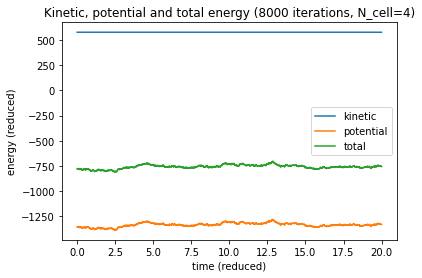

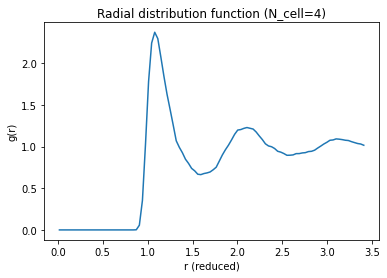

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi
from itertools import product

sigma = 0.3405  # nm
t0 = 2.157  # ps
n_bins = 100

T_0 = 1.50  # temperature
rho = 0.7976  # density of Argon in reduced units
# T_0 = 0.71  # temperature
# rho = 0.844  # density of Argon in reduced units

n_frames = 8000
dt = 20/n_frames  # time step size
N_cell = 4  # number of fcc unitcells in one direction
N = 4 * N_cell ** 3  # the total number of particles in the system
L_box = (N / rho) ** (1 / 3.0)  # length of the whole simulation box
L_cell = L_box / N_cell  # length of a unitcell
F = np.zeros((N, N, 3))  # matrix that contains all forces
ind = np.triu_indices(N, k=1)  # indices of upper triangular matrix


def IC_pos(N_cell, L_cell):
    '''
    use fcc structure to initilize positions
    '''
    pos = [[[x,  y, z],
            [x, 0.5 + y, 0.5 + z],
            [0.5 + x, y, 0.5 + z],
            [0.5 + x, 0.5 + y, z]]
           for x, y, z in product(range(N_cell), range(N_cell), range(N_cell))]
    pos = np.array(pos).reshape((-1, 3))
    return pos * L_cell


def IC_vel(N):
    '''
    Maxwell-Boltzman distribution is a normal distribution
    '''
    vel = np.sqrt(T_0) * np.random.randn(N, 3)
    vel -= np.average(vel, axis=0)
    return vel

def find_energy(pos, vel, L_box=L_box):
    r_vec = pos[ind[0]] - pos[ind[1]]
    r_vec = r_vec - np.rint(r_vec / L_box) * L_box
    r_sq = np.sum(r_vec**2, axis=1)
    pot = np.sum(4 / r_sq ** 6 - 4 / r_sq ** 3)
    kin = 0.5 * np.sum(vel**2)
    return kin, pot

def time_step(pos, vel):
    prop_pos = np.mod(pos + (np.random.rand(N, 3) - 0.5) * (np.sqrt(T_0) * dt) * 4, L_box)
    prop_vel = vel

    prop_kin, prop_pot = find_energy(prop_pos, prop_vel)
    kin, pot = find_energy(pos, vel)

    acc = np.minimum(1, np.exp(-1/(T_0) * (prop_pot - pot)))

    accepted = np.random.rand(1) < acc
    if accepted:
        vel, pos = prop_vel, prop_pos
        pot, kin = prop_pot, prop_kin
    else:
        vel, pos = vel, pos
        pot, kin = pot, kin
    return pos, vel, pot, kin, accepted


def simulate(f, h_r, bins, drs, dvs):
    kins, pots, Ps = [], [], []
    pos = IC_pos(N_cell, L_cell)
    prev_pos = pos
    vel = IC_vel(N)
    prev_vel = vel
    dr, dv = 0, 0
    # F = find_force(pos)[0]
    n_accepted = 0
    for i in range(5*n_frames):
        pos, vel, pot, kin, accepted = time_step(pos, vel)
        if i >= 4*n_frames:  # production run
            kins.append(kin)
            pots.append(pot)

            SI_pos = pos*sigma
            SI_vel = vel*sigma/t0

            r_vec = pos[ind[0]] - pos[ind[1]]
            r_vec = r_vec - np.rint(r_vec / L_box) * L_box
            r_sq = np.sum(r_vec**2, axis=1)
            h_r += np.histogram(np.sqrt(r_sq), bins)[0]
            n_accepted += int(accepted)
            
        else:  # equillirum run
            vel *= np.sqrt(N * 3 * T_0 / (2 * kin))
        prev_pos = pos
        prev_vel = vel
    
    print(n_accepted)
    return np.array(kins), np.array(pots), np.array(Ps)


# The simulation starts here
if __name__ == "__main__":
    h_r = np.zeros(n_bins)
    bins = np.linspace(0, L_box/2, n_bins+1)

    drs = []
    dvs = []

    with open('argon.gro', 'w') as f:
        kins, pots, Ps = simulate(f, h_r, bins, drs, dvs)
    times = np.arange(len(kins)) * dt

    # plot the energy vs time results
    plt.plot(times, kins)
    plt.plot(times, pots)
    plt.plot(times, kins+pots)
    plt.legend(['kinetic', 'potential', 'total'])
    plt.xlabel('time (reduced)')
    plt.ylabel('energy (reduced)')
    plt.title(f'Kinetic, potential and total energy ({n_frames} iterations, N_cell={N_cell})')
    plt.savefig('images/energy.png')
    plt.show()

    n_r = (h_r*2/((N-1)*(n_frames)))
    g_r = n_r/(4/3*pi*((bins[1:])**3 - (bins[:-1])**3)*rho)
    plt.plot(bins[:n_bins]+(bins[1]-bins[0])/2, g_r)
    plt.title(f'Radial distribution function (N_cell={N_cell})')
    plt.savefig(f'images/g_r(N_cell={N_cell}).png')
    plt.xlabel('r (reduced)')
    plt.ylabel('g(r)')
    plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi
from itertools import product

sigma = 0.3405  # nm
t0 = 2.157  # ps
n_bins = 100

T_0 = 1.50  # temperature
rho = 0.7976  # density of Argon in reduced units
# T_0 = 0.71  # temperature
# rho = 0.844  # density of Argon in reduced units

n_frames = 8000
dt = 20/n_frames  # time step size
N_cell = 5  # number of fcc unitcells in one direction
N = 4 * N_cell ** 3  # the total number of particles in the system
L_box = (N / rho) ** (1 / 3.0)  # length of the whole simulation box
L_cell = L_box / N_cell  # length of a unitcell
F = np.zeros((N, N, 3))  # matrix that contains all forces
ind = np.triu_indices(N, k=1)  # indices of upper triangular matrix


def IC_pos(N_cell, L_cell):
    '''
    use fcc structure to initilize positions
    '''
    pos = [[[x,  y, z],
            [x, 0.5 + y, 0.5 + z],
            [0.5 + x, y, 0.5 + z],
            [0.5 + x, 0.5 + y, z]]
           for x, y, z in product(range(N_cell), range(N_cell), range(N_cell))]
    pos = np.array(pos).reshape((-1, 3))
    return pos * L_cell


def IC_vel(N):
    '''
    Maxwell-Boltzman distribution is a normal distribution
    '''
    vel = np.sqrt(T_0) * np.random.randn(N, 3)
    vel -= np.average(vel, axis=0)
    return vel

def find_energy(pos, vel, L_box=L_box):
    r_vec = pos[ind[0]] - pos[ind[1]]
    r_vec = r_vec - np.rint(r_vec / L_box) * L_box
    r_sq = np.sum(r_vec**2, axis=1)
    pot = np.sum(4 / r_sq ** 6 - 4 / r_sq ** 3)
    kin = 0.5 * np.sum(vel**2)
    return kin, pot

def time_step(pos, vel):
    prop_pos = np.mod(pos + (np.random.rand(N, 3) - 0.5) * (np.sqrt(T_0) * dt) * 3, L_box)
    prop_vel = vel

    prop_kin, prop_pot = find_energy(prop_pos, prop_vel)
    kin, pot = find_energy(pos, vel)

    acc = np.minimum(1, np.exp(-1/(T_0) * (prop_pot - pot)))

    accepted = np.random.rand(1) < acc
    if accepted:
        vel, pos = prop_vel, prop_pos
        pot, kin = prop_pot, prop_kin
    else:
        vel, pos = vel, pos
        pot, kin = pot, kin
    return pos, vel, pot, kin, accepted


def simulate(f, h_r, bins, drs, dvs):
    kins, pots, Ps = [], [], []
    pos = IC_pos(N_cell, L_cell)
    prev_pos = pos
    vel = IC_vel(N)
    prev_vel = vel
    dr, dv = 0, 0
    # F = find_force(pos)[0]
    n_accepted = 0
    for i in range(5*n_frames):
        pos, vel, pot, kin, accepted = time_step(pos, vel)
        if i >= 4*n_frames:  # production run
            kins.append(kin)
            pots.append(pot)

            SI_pos = pos*sigma
            SI_vel = vel*sigma/t0

            r_vec = pos[ind[0]] - pos[ind[1]]
            r_vec = r_vec - np.rint(r_vec / L_box) * L_box
            r_sq = np.sum(r_vec**2, axis=1)
            h_r += np.histogram(np.sqrt(r_sq), bins)[0]
            n_accepted += int(accepted)
            
        else:  # equillirum run
            vel *= np.sqrt(N * 3 * T_0 / (2 * kin))
        prev_pos = pos
        prev_vel = vel
    
    print(n_accepted)
    return np.array(kins), np.array(pots), np.array(Ps)


# The simulation starts here
if __name__ == "__main__":
    h_r = np.zeros(n_bins)
    bins = np.linspace(0, L_box/2, n_bins+1)

    drs = []
    dvs = []

    with open('argon.gro', 'w') as f:
        kins, pots, Ps = simulate(f, h_r, bins, drs, dvs)
    times = np.arange(len(kins)) * dt

    # plot the energy vs time results
    plt.plot(times, kins)
    plt.plot(times, pots)
    plt.plot(times, kins+pots)
    plt.legend(['kinetic', 'potential', 'total'])
    plt.xlabel('time (reduced)')
    plt.ylabel('energy (reduced)')
    plt.title(f'Kinetic, potential and total energy ({n_frames} iterations, N_cell={N_cell})')
    plt.savefig('images/energy.png')
    plt.show()

    n_r = (h_r*2/((N-1)*(n_frames)))
    g_r = n_r/(4/3*pi*((bins[1:])**3 - (bins[:-1])**3)*rho)
    plt.plot(bins[:n_bins]+(bins[1]-bins[0])/2, g_r)
    plt.title(f'Radial distribution function (N_cell={N_cell})')
    plt.savefig(f'images/g_r(N_cell={N_cell}).png')
    plt.xlabel('r (reduced)')
    plt.ylabel('g(r)')
    plt.show()